In [ ]:
import sys
sys.path.append("..")
import torch
from iastar import iastar
from dastar import dastar
import matplotlib.pyplot as plt
from data_loader import create_dataloader
from utils import  visualize_results
from neural_astar.utils.training import load_from_ptl_checkpoint

from neural_astar.planner import NeuralAstar

device = "cuda" if torch.cuda.is_available() else "cpu"
neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/nastar/"))

def load_from_ptl_checkpoint(filename):
    return torch.load(filename)["model_state_dict"]
ia_planner = iastar(encoder_input=3,
                    encoder_arch="UNet",
                    device=device,
                    encoder_depth=3,
                    learn_obstacles=False,
                    is_training = True,
                    output_path_list= False,
                    w=2.0).to(device)
ia_planner.encoder.load_state_dict(load_from_ptl_checkpoint("../model/iastar/iastar1UNet.pkl"))
da_planner = dastar()


/Dpan/cxy1/anaconda3/envs/iastar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/Dpan/cxy1/anaconda3/envs/iastar/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Dpan/cxy1/anaconda3/envs/iastar/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/Dpan/cxy1/anaconda3/envs/iastar/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/Dpan/cxy1/anaconda3/envs/iastar/lib/python3.10/site-packages/pretrainedmodels/models/dpn.py:262: Synt

load ../model/nastar/mazes_032_moore_c8/lightning_logs/version_0/checkpoints/epoch=33-step=272.ckpt
Using %s as encoder UNet


Number of Test Samples: 100
	Size: 64x64


/home/cxy/.local/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


dastar finished.
nastar finished.
iastar finished.


(-0.5, 529.5, 67.5, -0.5)

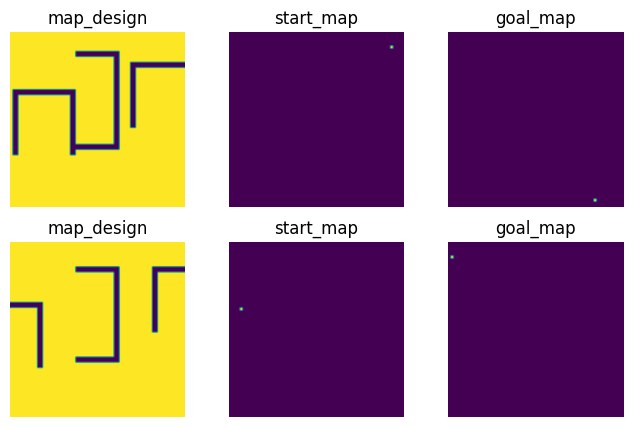

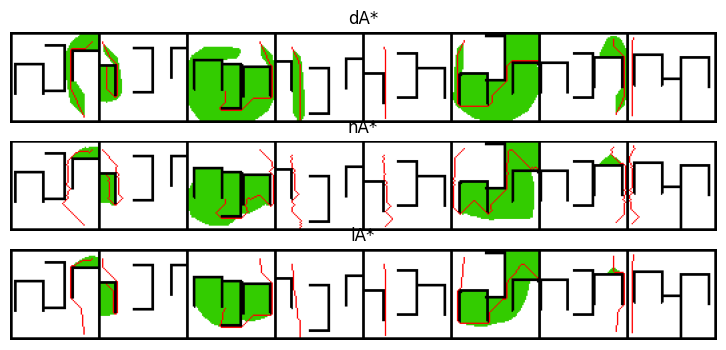

In [3]:
dataloader = create_dataloader("../planning-datasets/mpd/instances/064/multiple_bugtraps_064_moore_c16.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs = da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs = ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")

Number of Test Samples: 5
	Size: 64x64
dastar finished.
nastar finished.
iastar finished.


(-0.5, 331.5, 67.5, -0.5)

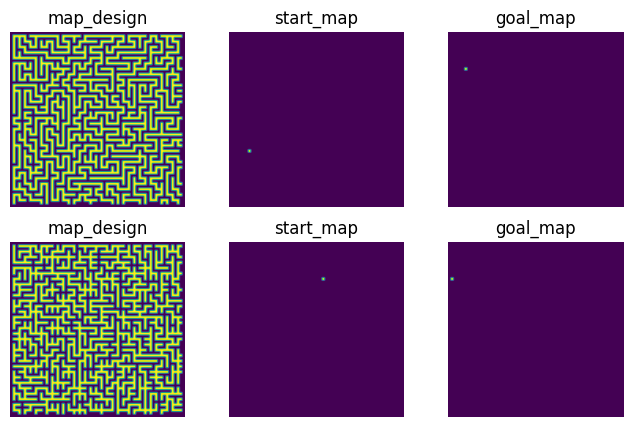

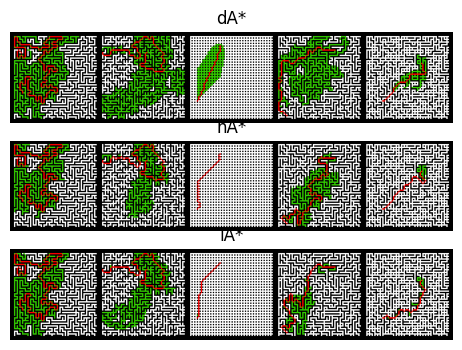

In [4]:
dataloader = create_dataloader("../planning-datasets/maze/instances/064/maze_064_moore_c16.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs = da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs = ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")

Number of Train Samples: 14
	Size: 64x64
dastar finished.
nastar finished.
iastar finished.


(-0.5, 529.5, 67.5, -0.5)

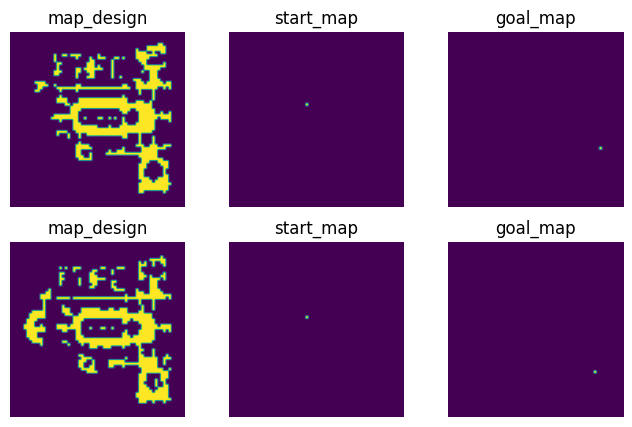

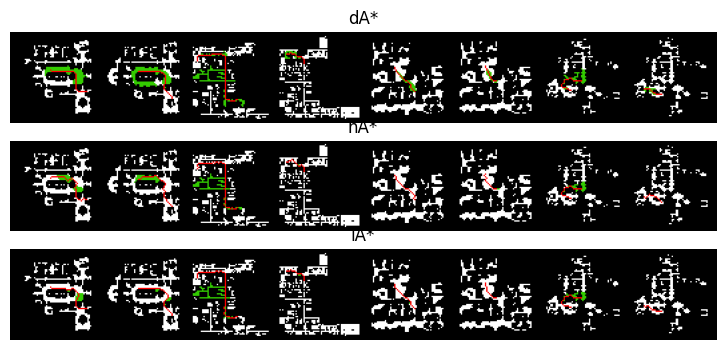

In [8]:
dataloader = create_dataloader("../planning-datasets/matterport/instances/064/tsdf_064_moore_c25.npz", "train", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs = da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs = ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")